# IS 4487 Lab 13

## Learning Objectives
1. Select appropriate variables for a cluster analysis
2. Learn to fit and adjust a cluster analysis model based on similar customer behavioural patterns.
3. Interpret the output of the model

## Lab Tasks
1. Import and prepare data using the *SuperStore Retail Orders* dataset
2. Convert categorical variables to numbers or boolean
3. Fit a K-means model with 5 clusters
4. Display and analyze the results

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab_13_retailer_cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Superstore Data Dictionary

 ORDER VARIABLES:
 - Order ID
 - Order Date
 - Order Year Month - Year and month of the order
 - Order Type - Was the order completed at a store or online? (Retail, Online)
 - Quantity - Quantity ordered for the product

 CUSTOMER VARIABLES:
 - Customer Name
 - City
 - State Province
 - Email


PRODUCT VARIABLES:
 - Product Name
 - Product Line - Category of the product (i.e. Bikes Phones)
 - Product Price - Price in US Dollars
 - Product Status - Current status of the product (Active, Inactive)

## Load Libraries

➡️ Assignment Tasks
- Load any other necessary libraries, in addition to those below

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

In [2]:
# Recommended additional libraries for preprocessing and visualization
from sklearn.preprocessing import StandardScaler  # 用于数据标准化
from sklearn.decomposition import PCA             # 可视化降维
import matplotlib.pyplot as plt                   # 绘图
import seaborn as sns                             # 更美观的图表（可选）

# Optional: display settings for better readability (适用于Jupyter/Colab环境)
pd.set_option('display.max_columns', None)

## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the SuperStore retail dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe

In [5]:
# Step 1: Import data into a DataFrame
# Use the 'raw' URL to access the raw CSV data from GitHub
df = pd.read_csv('https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/main/Labs/DataSets/superstore_retail_orders.csv')  # Changed URL to raw content URL

# Step 2: Preview the dataset
print("🔹 First 5 Rows:")
print(df.head())

# Step 3: Check DataFrame shape
print("\n🔹 DataFrame Shape:")
print(df.shape)

# Step 4: Display column names and types
print("\n🔹 DataFrame Info:")
print(df.info())

# Step 5: Basic statistics for numeric columns
print("\n🔹 Summary Statistics (numeric):")
print(df.describe())

# Optional: Check for missing values
print("\n🔹 Missing Values Count:")
print(df.isnull().sum())

🔹 First 5 Rows:
   order_id  order_date order_year_month  customer_name               city  \
0     51188  2023-07-01          2023-07  Audrey Blanco  North Cherylmouth   
1     51187  2023-07-01          2023-07    Isaac Allen         Traceyland   
2     51199  2023-07-02          2023-07     Ian Morgan          Dylanberg   
3     51241  2023-07-04          2023-07     Alexa Bell     Lake Tracytown   
4     51297  2023-07-08          2023-07     Casey Diaz        Byrdchester   

  state_province                    email order_type  quantity  \
0  New Hampshire  audrey_blanco@email.com     Retail       3.0   
1  West Virginia    isaac_allen@email.com     Online       4.0   
2   South Dakota     ian_morgan@email.com     Online       5.0   
3      Wisconsin     alexa_bell@email.com     Online       1.0   
4    Mississippi     casey_diaz@email.com     Online       1.0   

                                        product_name product_line  \
0  Apple iPhone XR (Yellow, 256 GB) (Includes Ear

## Prepare Data
Note that K-Means requires that all variables be numbers or boolean.  No categorical variables are allowed.

➡️ Assignment Tasks
- Copy your dataframe into a new version, so that the original data is still available
- Create any needed variables, such as month of year and total_amount.  
- Filter out any incomplete orders
- Convert the OrderType and Product Line variables to multiple one-hot variables using OneHotEncoder (one variable for each value)
- Remove any variables that will be not be included (hint: only numeric variables are allowed)
- Remove any outliers that will cause a cluster to be created for the few records with the outlier value (pay close attention to dates, quantities and prices)

*Notes:*
- There is no need to split the data for cluster analysis.  Why is that the case?
- You should think carefully about which variables to include.  They should be independent and numeric, and have some behavioural aspect for customers.  A date, for example, cannot be used unless it is somehow converted to a number.  

In [19]:
# Step 1: Copy original dataframe
df_clean = df.copy()

# Step 2: Create new variables: order_month and total_amount
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'], errors='coerce')
df_clean['order_month'] = df_clean['order_date'].dt.month
df_clean['total_amount'] = df_clean['quantity'] * df_clean['product_price']

# Step 3: Filter out incomplete or invalid records
df_clean = df_clean.dropna(subset=['order_type', 'quantity', 'product_line', 'product_price', 'order_date'])

# Step 4: One-hot encode categorical variables
from sklearn.preprocessing import OneHotEncoder

cat_vars = ['order_type', 'product_line']
# The 'sparse' argument was introduced in a later version of scikit-learn.
# If you are using an older version, remove this argument.
encoder = OneHotEncoder(drop='first')  # drop first to avoid multicollinearity
encoded = encoder.fit_transform(df_clean[cat_vars])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(cat_vars)) # Convert sparse matrix to dense array

# Step 5: Combine encoded and numeric features
df_model = pd.concat([
    df_clean[['quantity', 'product_price', 'order_month', 'total_amount']].reset_index(drop=True),
    encoded_df.reset_index(drop=True)
], axis=1)

# Step 6: Remove outliers using IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

df_model = remove_outliers_iqr(df_model, 'quantity')
df_model = remove_outliers_iqr(df_model, 'product_price')
df_model = remove_outliers_iqr(df_model, 'total_amount')

# Step 7: Final check
print("🔹 Final model data shape:", df_model.shape)
print("🔹 Sample of data used for clustering:")
print(df_model.head())


🔹 Final model data shape: (51575, 13)
🔹 Sample of data used for clustering:
   quantity  product_price  order_month  total_amount  order_type_Retail  \
0       3.0         649.99          7.0       1949.97                1.0   
3       1.0         649.99          7.0        649.99                0.0   
4       1.0         649.99          7.0        649.99                0.0   
5       1.0         649.99          7.0        649.99                0.0   
6       1.0         649.99          7.0        649.99                0.0   

   product_line_Bikes  product_line_Cameras  product_line_Clothing  \
0                 0.0                   0.0                    0.0   
3                 0.0                   0.0                    0.0   
4                 0.0                   0.0                    0.0   
5                 0.0                   0.0                    0.0   
6                 0.0                   0.0                    0.0   

   product_line_Electronics  product_line_Lapt

## Create Model

For more info on K-means in python, see: https://realpython.com/k-means-clustering-python/

➡️ Assignment Tasks
- Fit the K-means model using the Kmeans method
- Use 5 clusters

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data (if not already done)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model)

# Step 2: Create and fit KMeans model with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(scaled_data)

# Step 3: Get cluster labels
cluster_labels = kmeans.labels_

# Step 4: Add cluster labels back to your cleaned dataset (aligned by index)
df_clean = df_clean.iloc[df_model.index].copy()
df_clean['cluster'] = cluster_labels

# Optional: print cluster counts
print("🔹 Cluster size distribution:")
print(df_clean['cluster'].value_counts())


🔹 Cluster size distribution:
cluster
0    21925
1    15211
3     7579
4     5108
2     1752
Name: count, dtype: int64


## Analyze the Clusters

➡️ Assignment Tasks
- create at least two visualizations to show the clusters (try a Bar Chart, Pair Plot or Scatter Plot)
- Display the cluster and mean values for each of the variables

🔹 Cluster Mean Values:
         quantity  product_price  order_month  total_amount
cluster                                                    
0        1.944629      11.241283     6.361277     17.405593
1        1.327460     697.004200     6.360857    915.153926
2        1.001142    1013.876210     6.389840   1014.618208
3        1.000000    1688.767304     6.298852   1688.767304
4        1.102780      51.314368     6.349060     52.238359


<ipython-input-21-5153c938c6de>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df_clean, palette='Set2')


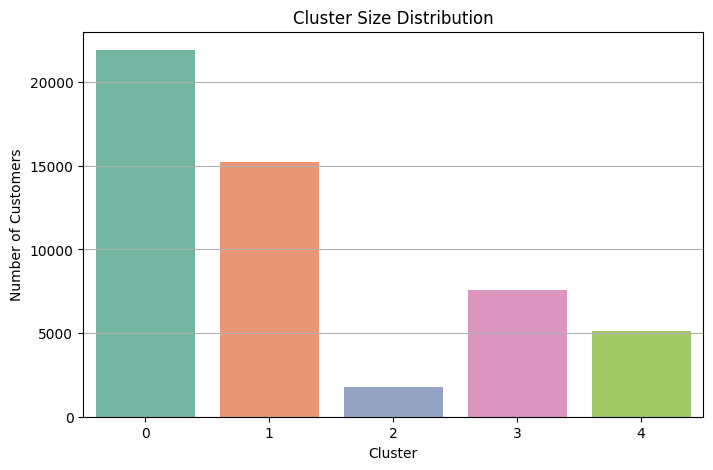

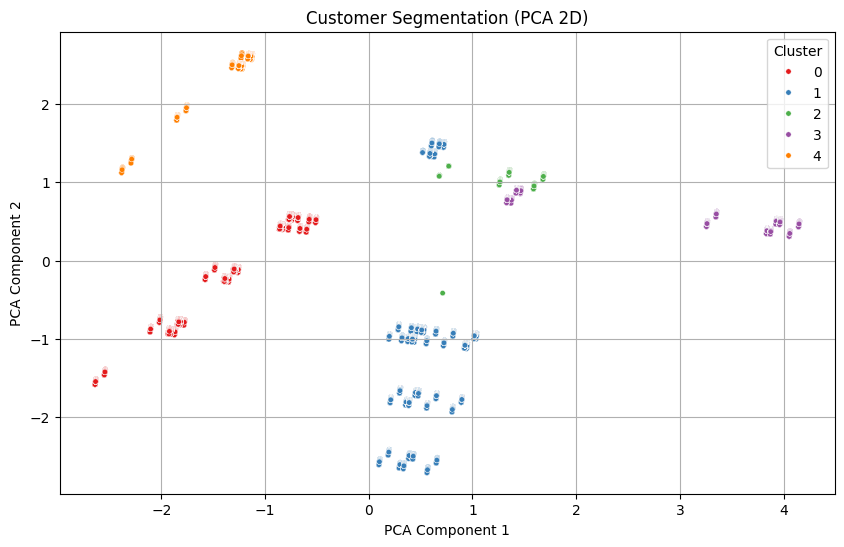

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Cluster Summary Statistics (平均值)
cluster_summary = df_clean.groupby('cluster')[['quantity', 'product_price', 'order_month', 'total_amount']].mean()
print("🔹 Cluster Mean Values:")
print(cluster_summary)

# Optional: 可导出成CSV
# cluster_summary.to_csv("cluster_summary.csv", index=True)

# ---------------------------
# Visualization #1: Bar Chart of Cluster Sizes
# ---------------------------
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=df_clean, palette='Set2')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.show()

# ---------------------------
# Visualization #2: PCA Scatter Plot (Cluster Separation View)
# ---------------------------
from sklearn.decomposition import PCA

# Reuse the scaled data from before
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df_clean['cluster'], palette='Set1', s=15)
plt.title('Customer Segmentation (PCA 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
